In [24]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import analysis_utils as au
import CMR_IA as cmr
from matplotlib.lines import Line2D
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
SAVE_FIG = False

In [25]:
with open("simu1_data/simu1_design.pkl", 'rb') as inp:
    df = pickle.load(inp)
df = df.loc[df.session < 100]
df

,subject_ID,position,item,itemno,category_label,lag,old,session,study_itemno1,study_itemno2,test_itemno1,test_itemno2
0,58,0,UNDERWEAR,282,Clothing,0,False,0,282,-1,282,-1
1,58,1,JEANS,139,Clothing,0,False,0,139,-1,139,-1
2,58,2,JACKET,138,Clothing,0,False,0,138,-1,138,-1
3,58,3,TABLET,263,Electronics,0,False,0,263,-1,263,-1
4,58,4,COMPUTER,62,Electronics,0,False,0,62,-1,62,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
579995,337,575,LAKE,148,Landscapes,0,False,999,148,-1,148,-1
579996,337,576,PIE,201,Desserts,78,True,999,201,-1,201,-1
579997,337,577,LOBSTER,160,OceanAnimals,90,True,999,160,-1,160,-1
579998,337,578,MAPLE,161,Trees,118,True,999,161,-1,161,-1


### Run CMR-IA

In [26]:
s_mat = np.load('simu1_data/simu1_300_smat.npy')

In [27]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.05,
    beta_rec = 0,
    beta_cue = 0,
    beta_rec_post = 0.01,
    gamma_fc = 0.1,
    s_fc = 0.1,
    c_thresh_itm = 0.56,
    use_new_context = False,
)
params

{'beta_enc': 0.05,
 'beta_rec': 0,
 'beta_cue': 0,
 'beta_rec_post': 0.01,
 'beta_distract': None,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.1,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 5,
 'alpha': 1,
 'c_thresh': 0.5,
 'c_thresh_itm': 0.56,
 'c_thresh_ass': 0.5,
 'd_ass': 1,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.1,
 'gamma_cf': 0.5,
 'use_new_context': False}

In [28]:
df_simu = cmr.run_conti_recog_multi_sess(params,df,s_mat,mode='Continuous')

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 7/1000 [00:05<13:47,  1.20it/s]


KeyboardInterrupt: 

In [ ]:
df_simu = df_simu.merge(df,on=['session','position','study_itemno1','study_itemno2','test_itemno1','test_itemno2'])
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old
0,0,0,282,-1,282,-1,0.0,0.038288,0.000000,58,UNDERWEAR,282,Clothing,0,False
1,0,1,139,-1,139,-1,0.0,0.052787,0.016057,58,JEANS,139,Clothing,0,False
2,0,2,138,-1,138,-1,0.0,0.073945,0.032910,58,JACKET,138,Clothing,0,False
3,0,3,263,-1,263,-1,0.0,0.084753,0.039731,58,TABLET,263,Electronics,0,False
4,0,4,62,-1,62,-1,0.0,0.123985,0.058752,58,COMPUTER,62,Electronics,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57995,99,575,186,-1,186,-1,0.0,1828.119141,0.538683,91,OVEN,186,Appliances,65,True
57996,99,576,37,-1,37,-1,1.0,720.937500,0.627841,91,CAKE,37,Desserts,54,True
57997,99,577,233,-1,233,-1,1.0,2571.516113,0.564256,91,SHEEP,233,FarmAnimals,97,True
57998,99,578,89,-1,89,-1,1.0,1100.150024,0.606709,91,DRUM,89,Instruments,64,True


### Preprocesssing

In [ ]:
# calculate the rolling category length
rolling_window = 9
category_label_dummies = df_simu['category_label'].str.get_dummies()
category_label_dummies.columns = ['cl_' + col for col in category_label_dummies.columns]
category_label_dummies_events = pd.concat([df_simu, category_label_dummies], axis=1)
cl_rolling_sum = category_label_dummies_events.groupby('session').rolling(rolling_window, min_periods=1, on='position')[category_label_dummies.columns].sum().reset_index()
df_rollcat = df_simu.merge(cl_rolling_sum, on=['session', 'position'])
df_simu['roll_cat_label_length'] = df_rollcat.apply(lambda x: x['cl_' + x['category_label']], 1) # how many cat within 10 window
df_simu['roll_cat_label_length'] = df_simu['roll_cat_label_length'] - 1 # how many cat in previous 9 window. not include self

# add rolling category length level
df_simu['roll_cat_len_level']= pd.cut(x=df_simu.roll_cat_label_length, 
                                bins=[0, 1, 2, np.inf], right=False, include_lowest = True,
                                labels=['0', '1', '>=2']).astype('str')

df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old,roll_cat_label_length,roll_cat_len_level
0,0,0,282,-1,282,-1,0.0,0.038288,0.000000,58,UNDERWEAR,282,Clothing,0,False,0.0,0
1,0,1,139,-1,139,-1,0.0,0.052787,0.016057,58,JEANS,139,Clothing,0,False,1.0,1
2,0,2,138,-1,138,-1,0.0,0.073945,0.032910,58,JACKET,138,Clothing,0,False,2.0,>=2
3,0,3,263,-1,263,-1,0.0,0.084753,0.039731,58,TABLET,263,Electronics,0,False,0.0,0
4,0,4,62,-1,62,-1,0.0,0.123985,0.058752,58,COMPUTER,62,Electronics,0,False,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57995,99,575,186,-1,186,-1,0.0,1828.119141,0.538683,91,OVEN,186,Appliances,65,True,1.0,1
57996,99,576,37,-1,37,-1,1.0,720.937500,0.627841,91,CAKE,37,Desserts,54,True,0.0,0
57997,99,577,233,-1,233,-1,1.0,2571.516113,0.564256,91,SHEEP,233,FarmAnimals,97,True,1.0,1
57998,99,578,89,-1,89,-1,1.0,1100.150024,0.606709,91,DRUM,89,Instruments,64,True,0.0,0


In [ ]:
# df_simu.to_pickle("simu1_data/simu1_result.pkl")

### Recency

In [ ]:
# with open("simu1_data/simu1_result.pkl", 'rb') as inp:
#     df_simu = pickle.load(inp)

In [ ]:
# focus on old items
df_old = df_simu.loc[df_simu.lag > 0].reset_index(drop=True)

# add log and log lag bin
df_old['log_lag'] = np.log(df_old['lag'])
df_old['log_lag_bin'] = pd.cut(df_old['log_lag'], np.arange(df_old['log_lag'].max()+1), labels=False, right=False)
df_old

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin
0,0,22,138,-1,138,-1,0.0,23.555719,0.321100,58,JACKET,138,Clothing,20,True,0.0,0,2.995732,2
1,0,25,234,-1,234,-1,0.0,42.431076,0.350525,58,SHELF,234,Furniture,13,True,1.0,1,2.564949,2
2,0,26,72,-1,72,-1,0.0,41.228359,0.349088,58,CROWBAR,72,Tools,19,True,0.0,0,2.944439,2
3,0,28,238,-1,238,-1,0.0,67.302078,0.373591,58,SHOVEL,238,Tools,19,True,1.0,1,2.944439,2
4,0,29,263,-1,263,-1,0.0,53.441967,0.362061,58,TABLET,263,Electronics,26,True,0.0,0,3.258097,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,99,575,186,-1,186,-1,0.0,1828.119141,0.538683,91,OVEN,186,Appliances,65,True,1.0,1,4.174387,4
27996,99,576,37,-1,37,-1,1.0,720.937500,0.627841,91,CAKE,37,Desserts,54,True,0.0,0,3.988984,3
27997,99,577,233,-1,233,-1,1.0,2571.516113,0.564256,91,SHEEP,233,FarmAnimals,97,True,1.0,1,4.574711,4
27998,99,578,89,-1,89,-1,1.0,1100.150024,0.606709,91,DRUM,89,Instruments,64,True,0.0,0,4.158883,4


In [ ]:
# df_lagcnt = df_simu.groupby(['lag']).s_resp.count().to_frame(name='cnt').reset_index()
# df_lagcnt = df_lagcnt.loc[(df_lagcnt.lag <= 41) & (df_lagcnt.lag > 0)]
# # df_lagcnt

In [ ]:
# df_laggp = df_simu.groupby(['lag']).s_resp.mean().to_frame(name='hr').reset_index()
# df_laggp.lag = df_laggp.lag.astype('int')
# df_laggp = df_laggp.loc[(df_laggp.lag <= 41) & (df_laggp.lag > 0)]

# selected_lag = np.array([0,1,2,4,6,8,16,24,32,40])
# selected_lag_1 = selected_lag + 1
# df_laggp = df_laggp.loc[np.isin(df_laggp.lag, selected_lag_1)]
# df_laggp

In [ ]:
# # plt.subplots(figsize=(10,5))
# sns.lineplot(data=df_laggp, x='lag', y='hr', linewidth=2, marker='o', markersize = 7)
# plt.xlabel('Lag')
# plt.ylabel('P("yes"|old)')
# plt.xlim([-1,42])
# plt.xticks(ticks=selected_lag_1, labels = selected_lag)
# # plt.savefig('fig/simu1_recency.pdf')
# plt.show()

### Recency & Similarity

,lag,roll_cat_len_level,csim
1,1,>=2,0.604034
3,2,>=2,0.597319
5,3,>=2,0.599056
7,4,>=2,0.601796
9,5,>=2,0.599531
...,...,...,...
105,38,>=2,0.556350
106,39,0,0.568273
108,39,>=2,0.571012
109,40,0,0.585509


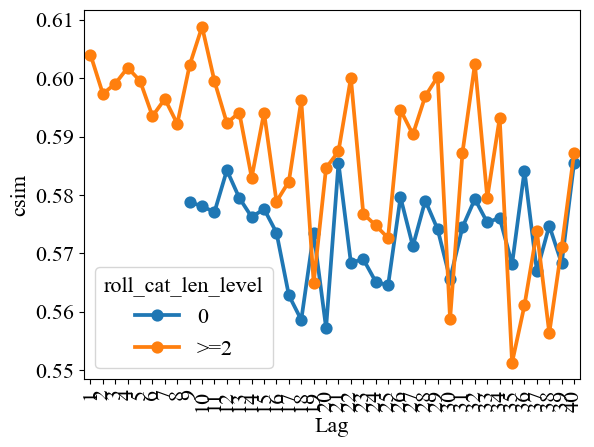

In [ ]:
df_laggp = df_old.groupby(['lag','roll_cat_len_level']).csim.mean().to_frame(name='csim').reset_index()
df_laggp.lag = df_laggp.lag.astype('int')
df_laggp = df_laggp.loc[(df_laggp.lag <= 40) & (df_laggp.lag > 0)]
df_laggp = df_laggp.loc[np.isin(df_laggp.roll_cat_len_level, ['0', '>=2'])]
df_laggp.roll_cat_len_level = df_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '>=2'])
display(df_laggp)

sns.pointplot(data=df_laggp, y='csim', x='lag', hue = 'roll_cat_len_level')
plt.xlabel('Lag')
plt.ylabel('csim')
plt.xticks(rotation=90)
# plt.savefig('result/behav_hit_recency.jpg')
plt.show()

In [ ]:
def loglag_rollcat(df, resp_col):

    df_rollcat_laggp = df.groupby(['session','roll_cat_len_level','log_lag_bin'])[resp_col].mean()
    df_rollcat_laggp = df_rollcat_laggp.to_frame(name='hr').reset_index()    
    df_rollcat_laggp = df_rollcat_laggp.loc[np.isin(df_rollcat_laggp.roll_cat_len_level,['0','>=2'])]
    df_rollcat_laggp.roll_cat_len_level = df_rollcat_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '>=2'])
    
    return df_rollcat_laggp

In [ ]:
df_old['log_lag_bin'] = df_old.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
df_rollcat_laggp = loglag_rollcat(df_old.query('log_lag_bin <= 5'),'s_resp')
df_rollcat_laggp['log_lag_disp'] = np.ceil(np.e**df_rollcat_laggp.log_lag_bin)
df_rollcat_laggp
# 1~7 -> 1(0,1), 8~20 -> 8(2), 21~54 -> 21(3), 55~148 -> 55(4), 149~403 -> 149(5)

,session,roll_cat_len_level,log_lag_bin,hr,log_lag_disp
0,0,0,2,0.818182,8.0
1,0,0,3,0.767857,21.0
2,0,0,4,0.560000,55.0
3,0,0,5,0.680000,149.0
9,0,>=2,0,0.814815,1.0
...,...,...,...,...,...
1280,99,>=2,0,0.923077,1.0
1281,99,>=2,2,0.857143,8.0
1282,99,>=2,3,1.000000,21.0
1283,99,>=2,4,1.000000,55.0


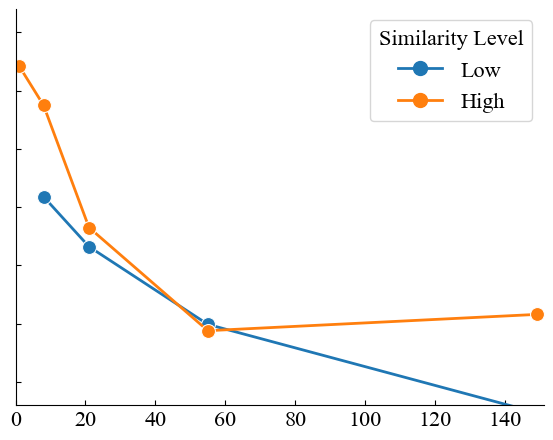

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_rollcat_laggp, y='hr', x='log_lag_disp', hue = 'roll_cat_len_level', errorbar = None, marker = 'o', markersize = 10, lw=2)
plt.ylabel('P("Yes" | Old)')
plt.xlabel('Lag')
ax.set(xlabel=None, ylabel=None)
plt.tick_params(labelleft=False)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.58,0.92])
plt.xlim([0,151])
legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='-',label = 'Low'),
                   Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='-', label = 'High')]
plt.legend(handles = legend_elements, title = "Similarity Level")

if SAVE_FIG:
    plt.savefig('simu1_fig/simu1_recsim.pdf')

### RT

In [ ]:
# df_laggp = df_simu.groupby('lag').s_rt.mean().to_frame(name='rt_mean').reset_index()
# df_laggp.lag = df_laggp.lag.astype('int')
# df_laggp = df_laggp.loc[df_laggp.lag <= 40]
# # df_laggp = df_laggp.loc[(df_laggp.lag <= 40) & (df_laggp.lag > 0)]
# # df_laggp = df_laggp.loc[df_laggp.lag.isin([1,2,4,8,16,32,40])]
# sns.scatterplot(data=df_laggp, y='rt_mean', x='lag')
# plt.xlabel('lag')
# plt.ylabel('s_rt')
# plt.show()